In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#imported all necessary libraries

#for aesthetics
%matplotlib inline
sns.set_style('whitegrid')

#loading the data
data = pd.read_csv('retail_sales_dataset.csv')

#Preview of data
data.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [3]:
#exploring the dataset
print(f'Rows: {data.shape[0]}, Columns: {data.shape[1]}')

#check for missing values
data.isnull().sum()

#Run the different datatypes
data.dtypes

Rows: 1000, Columns: 9


Transaction ID       int64
Date                object
Customer ID         object
Gender              object
Age                  int64
Product Category    object
Quantity             int64
Price per Unit       int64
Total Amount         int64
dtype: object

In [5]:
#convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

#sort by date
data = data.sort_values('Date')

#Aggregate sales per day
daily_sales = data.groupby('Date')['Total Amount'].sum().reset_index()

#Rename for Prophet compatibility
daily_sales.columns = ['ds', 'y']

#preview_sales.head()
daily_sales.head()

,ds,y
0,2023-01-01,3600
1,2023-01-02,1765
2,2023-01-03,600
3,2023-01-04,1240
4,2023-01-05,1100


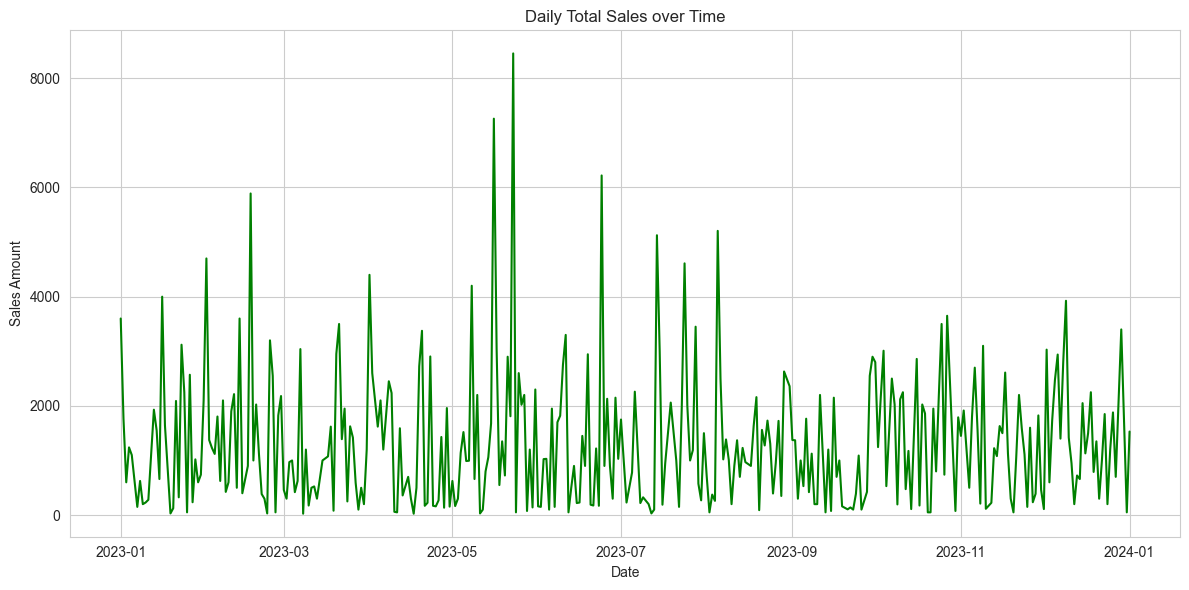

In [6]:
#visualize daily sales

plt.figure(figsize = (12, 6))
plt.plot(daily_sales['ds'], daily_sales['y'], color = 'green')
plt.title('Daily Total Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.tight_layout()
plt.show()

Daily sales are highly variable.
We see Spikes in sales around month of May to June 2023, which could indicate
1. Promotional events,
2. Holidays or seasonal purchases
3. Could be entry anomalies(worth double-checking)

C:\Users\ELITEX21012G2\AppData\Local\Temp\ipykernel_1352\203708042.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = daily_sales.set_index('ds').resample('M').sum()


Text(0, 0.5, 'Sales Amount')

<Figure size 1200x600 with 0 Axes>

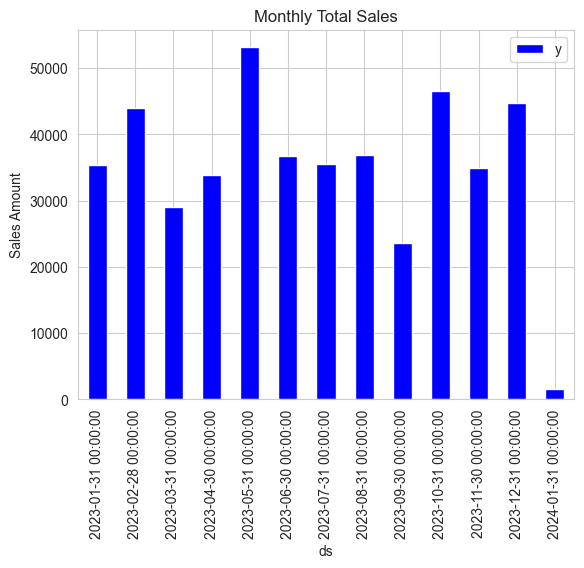

In [7]:
#define the variable daily_sales
daily_sales = data.groupby('Date')['Total Amount'].sum().reset_index()
daily_sales = daily_sales.rename(columns ={'Date': 'ds', 'Total Amount':'y'})

#To uncover deeper insights, we resample by month
monthly_sales = daily_sales.set_index('ds').resample('M').sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', color='blue')
plt.title('Monthly Total Sales')
plt.ylabel('Sales Amount')

1. May 2023 has the highest sales, crossing over 50,000. This could be an indication of promotion or product launch
2. We notice almost no sales in January 2024 which could suggest a major disruption occured or incomplete data.
3. sales are generally consistent, hovering between 30,000 and 45,000 for the most part of the year

Product performace Analysis


In [8]:
#Group by product
product_perf = data.groupby('Product Category').agg({
    'Total Amount': 'sum',
    'Quantity': 'sum',
    'Price per Unit': 'mean'
}).reset_index()

#Sort by total sales
product_perf = product_perf.sort_values('Total Amount', ascending = False)
product_perf.head

<bound method NDFrame.head of   Product Category  Total Amount  Quantity  Price per Unit
2      Electronics        156905       849      181.900585
1         Clothing        155580       894      174.287749
0           Beauty        143515       771      184.055375>

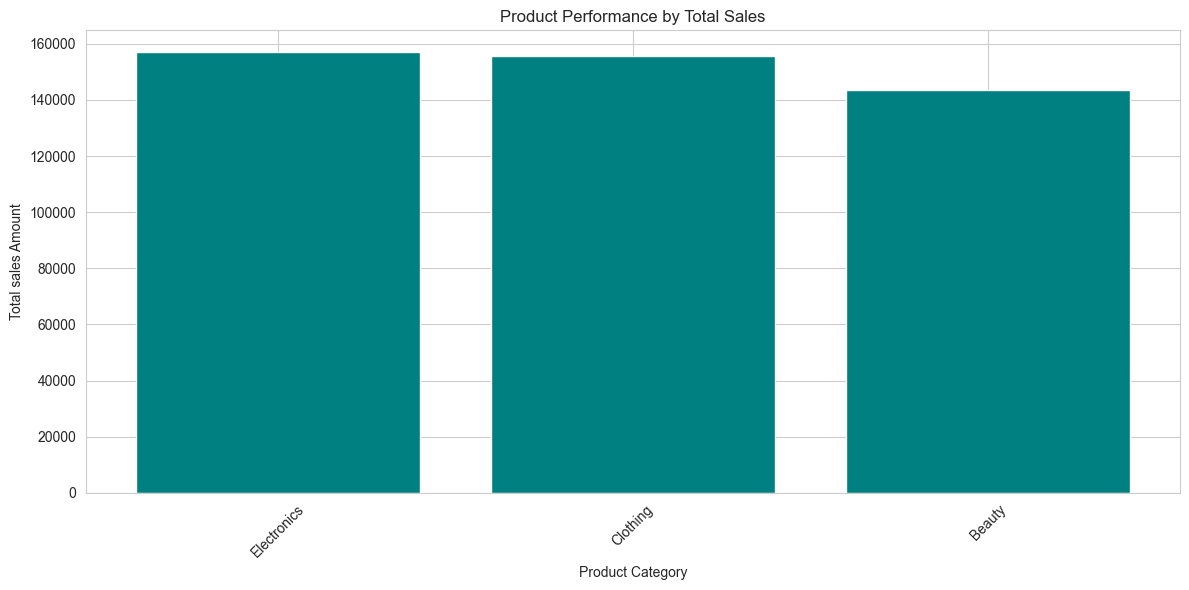

In [9]:
#Plots Top Products by Sales
plt.figure(figsize = (12,6))
plt.bar(product_perf['Product Category'], product_perf['Total Amount'], color = 'teal')
plt.title('Product Performance by Total Sales')
plt.xlabel('Product Category')
plt.ylabel('Total sales Amount')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

Determining Units Sold vs Sales Revenue
-Using a scatter plot to explore whether high sales revenue comes from high price or high quantities:


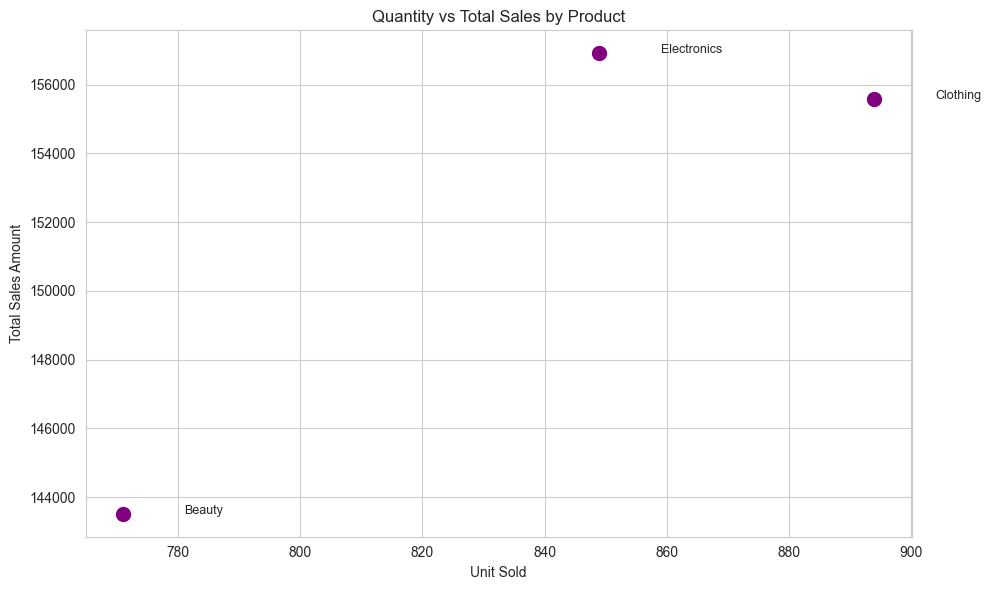

In [10]:
plt.figure(figsize = (10, 6))
plt.scatter(product_perf['Quantity'], product_perf['Total Amount'], color = 'purple', s = 100)

for i in range(len(product_perf)):
    plt.text(product_perf['Quantity'].iloc[i]+10,
             product_perf['Total Amount'].iloc[i],
             product_perf['Product Category'].iloc[i],
             fontsize = 9)

plt.title('Quantity vs Total Sales by Product')
plt.xlabel('Unit Sold')
plt.ylabel('Total Sales Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

Insights
1. we can see that beauty products are poor performers in contribution to sales, low quantities sold which relates to low revenues
2. On the other hand, Electronics and clothing are our star products driving sales revenues

Performing product analysis to understand
1. Which products are popular among men vs women?
2. Which gender drives more revenue for specific products?

In [11]:
#Group by gender and product category
product_gender_sales = data.groupby(['Product Category', 'Gender'])['Total Amount'].sum().reset_index()

#preview the data
product_gender_sales.head()

,Product Category,Gender,Total Amount
0,Beauty,Female,74830
1,Beauty,Male,68685
2,Clothing,Female,81275
3,Clothing,Male,74305
4,Electronics,Female,76735


In [12]:
#Reshaping the data to get gender as coloumns
pivot_table = product_gender_sales.pivot(index ='Product Category', columns = 'Gender', values ='Total Amount').fillna(0)

#preview
pivot_table.head()

Gender,Female,Male
Product Category,,
Beauty,74830,68685
Clothing,81275,74305
Electronics,76735,80170


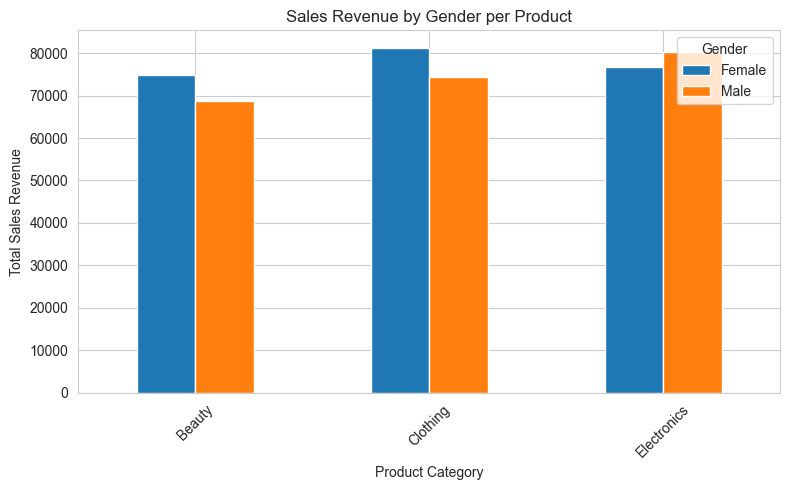

In [13]:
#Visualizatio, side by side plot
pivot_table.plot(kind = 'bar', figsize =(8,5))

plt.title('Sales Revenue by Gender per Product')
plt.ylabel('Total Sales Revenue')
plt.xlabel('Product Category')
plt.xticks(rotation = 45)
plt.legend(title = 'Gender')
plt.tight_layout()
plt.show()

In [14]:
#Aggregate Monthly Sales by product category
monthly_sales = data.groupby([
    pd.Grouper(key= 'Date',freq = 'M'),
    'Product Category'
])['Total Amount'].sum().reset_index()

monthly_sales.columns = ['ds', 'product', 'y']

#preview
monthly_sales.head()

C:\Users\ELITEX21012G2\AppData\Local\Temp\ipykernel_1352\4120827197.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key= 'Date',freq = 'M'),


,ds,product,y
0,2023-01-31,Beauty,12430
1,2023-01-31,Clothing,13125
2,2023-01-31,Electronics,9895
3,2023-02-28,Beauty,14035
4,2023-02-28,Clothing,14560


22:43:41 - cmdstanpy - INFO - Chain [1] start processing
22:43:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ELITEX21012G2\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


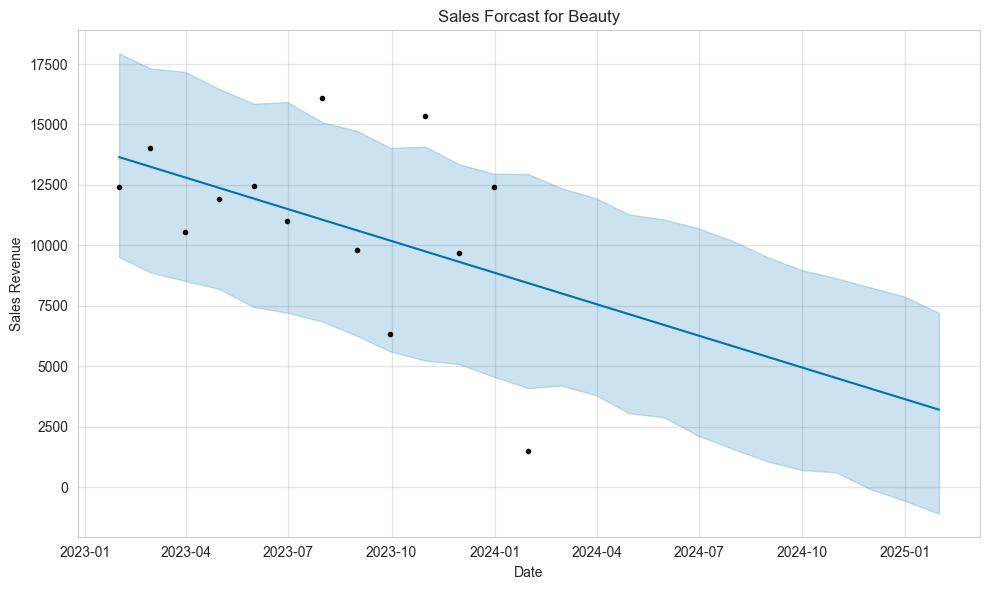

22:43:42 - cmdstanpy - INFO - Chain [1] start processing
22:43:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ELITEX21012G2\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


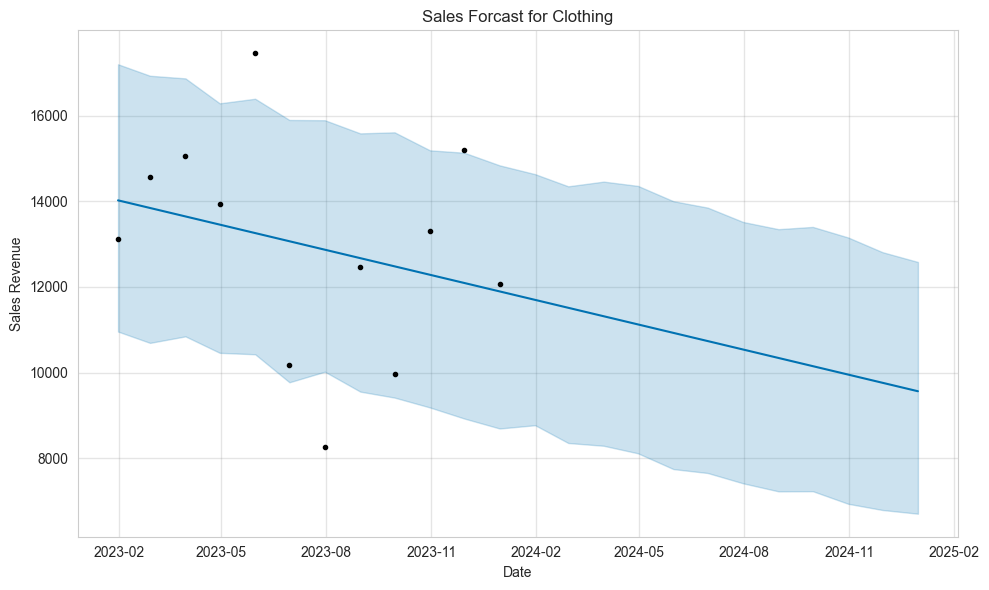

22:43:43 - cmdstanpy - INFO - Chain [1] start processing
22:43:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ELITEX21012G2\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


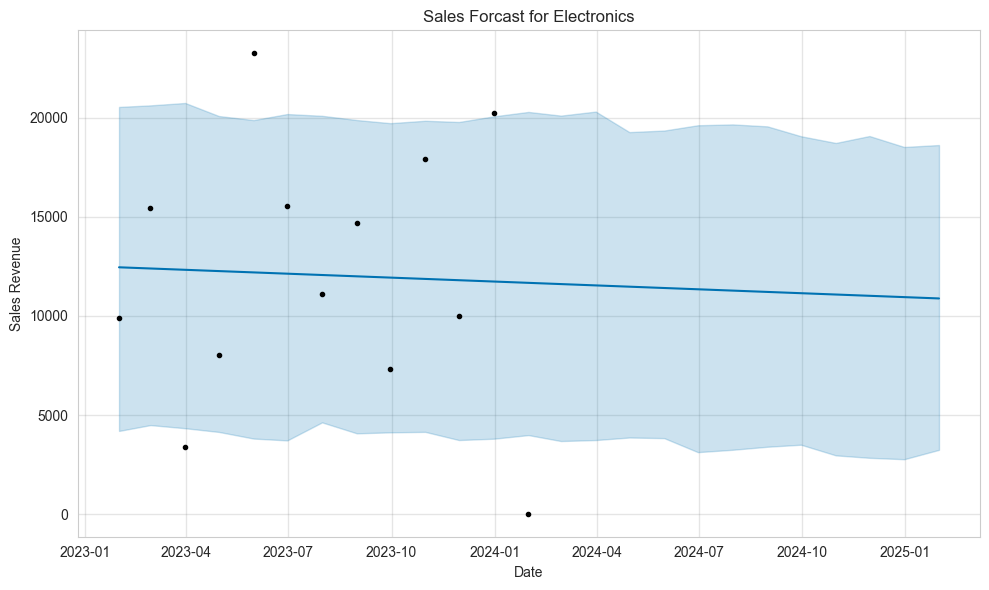

In [18]:
#forecast for All products Using Prophet
from prophet import Prophet 

#unique product Categories
products = monthly_sales['product'].unique()

#Dictionary to store forecasts
forecasts = {}

#Loop throughh each product and forecast
for product in products:
    product_data = monthly_sales[monthly_sales['product']== product][['ds','y']]
    
    #Initial model
    model = Prophet()
    model.fit(product_data)

    # Create future data frame(12 month ahead)
    future = model.make_future_dataframe(periods =12, freq ='M')

    #forcast
    forecast = model.predict(future)

    #save forcast
    forecasts[product] = forecast

    #plot
    model.plot(forecast)
    plt.title(f'Sales Forcast for {product}')
    plt.xlabel('Date')
    plt.ylabel('Sales Revenue')
    plt.tight_layout()
    plt.show()


In [19]:
# Combine all forecasts for export or dashboard
all_forecasts = []

for product, forecast in forecasts.items():
    temp = forecast[['ds', 'yhat']].copy()
    temp['product'] = product
    all_forecasts.append(temp)

final_forecast = pd.concat(all_forecasts, ignore_index=True)

# Save to CSV
final_forecast.to_csv('product_sales_forecasts.csv', index=False)
